In [170]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [171]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

In [172]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [173]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [174]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [175]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [176]:
def process_partition(data, n_components):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    for i in range(2):
        for j in range(2):
            part = data[i*16:i*16+16, j*16:j*16+16, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [177]:
def merge(data, partition, n_components):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((1024, 1024))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [178]:
def run_pca(data, n_components=100):
    
    start = time.time()
    
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    # reformat data into sig and nav dimension
    data = data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))

    partition = process_partition(data, n_components)
    data_transformed, reconstructed_data = merge(data, partition, n_components)
    
    end = time.time()
    print(f"Takes {end-start} sec")
    
    orig_data = data.reshape((sig_dim**2, nav_dim**2))
    print("norm difference between original and reconstructed data: ", diffsnorm(reconstructed_data, orig_data))
            
    return data_transformed

# Data generated using 100 components vs Noisy data (w/ dimension 1024)

In [179]:
component = ortho_group.rvs(dim=1024)[:100, :]
loading = np.random.rand(1024, 100)

data = loading @ component
data.shape, component.shape

((1024, 1024), (100, 1024))

In [180]:
noise_data = np.random.rand(1024, 1024)

In [181]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2501114931943771
norm difference wih 20 components using full batch data: 0.22531031135282428
norm difference wih 30 components using full batch data: 0.20198910910209847
norm difference wih 40 components using full batch data: 0.1794187950787392
norm difference wih 50 components using full batch data: 0.15725700992360364
norm difference wih 60 components using full batch data: 0.13495514616752158
norm difference wih 70 components using full batch data: 0.1119994065487438
norm difference wih 80 components using full batch data: 0.08759811739845562
norm difference wih 90 components using full batch data: 0.05921123382253521
norm difference wih 100 components using full batch data: 5.403871706341981e-16
norm difference wih 110 components using full batch data: 5.342171879516894e-16
norm difference wih 120 components using full batch data: 5.376257137437134e-16
norm difference wih 130 components using full batch data: 5.3927665884

In [182]:
for n_component in range(10, 200, 10):
    U, S, V = svd(noise_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2711729002288293
norm difference wih 20 components using full batch data: 0.2651399225242224
norm difference wih 30 components using full batch data: 0.2593267137466164
norm difference wih 40 components using full batch data: 0.25370200278789073
norm difference wih 50 components using full batch data: 0.24826082352167508
norm difference wih 60 components using full batch data: 0.24296030635530325
norm difference wih 70 components using full batch data: 0.2378022941223232
norm difference wih 80 components using full batch data: 0.2327781909477122
norm difference wih 90 components using full batch data: 0.22787250271775894
norm difference wih 100 components using full batch data: 0.22307643608329594
norm difference wih 110 components using full batch data: 0.2183818293882019
norm difference wih 120 components using full batch data: 0.21379495389399794
norm difference wih 130 components using full batch data: 0.20931278393203462
n

In [183]:
data_transformed = run_pca(data)

Takes 1.8112530708312988 sec
norm difference between original and reconstructed data:  6.09539747758364e-16


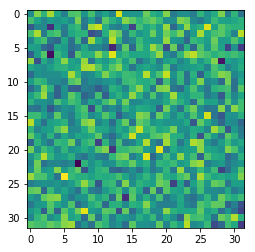

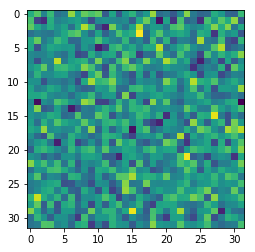

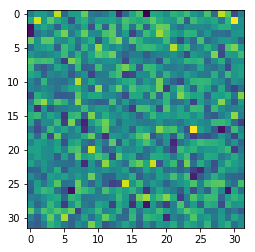

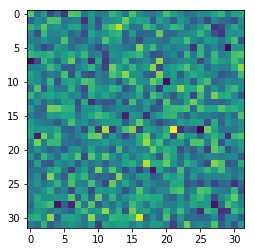

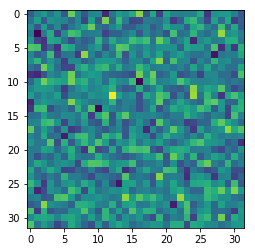

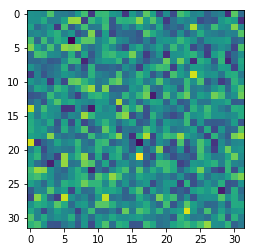

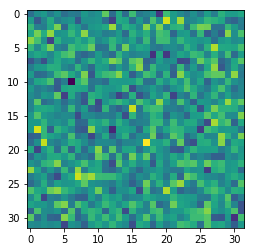

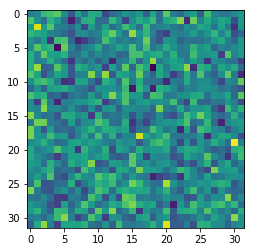

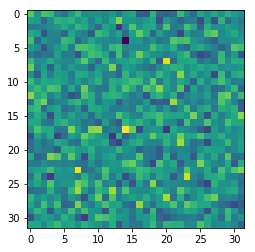

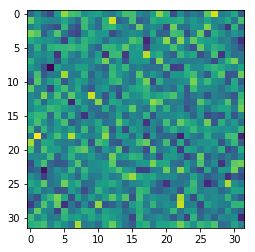

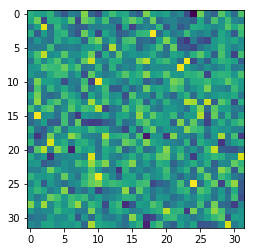

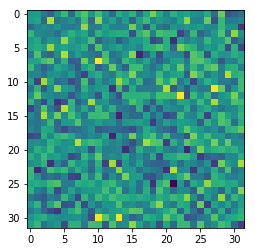

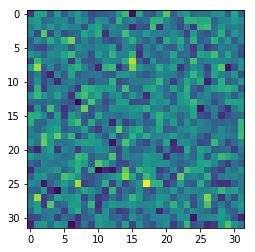

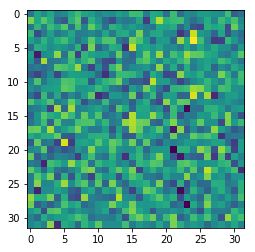

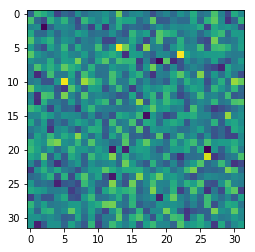

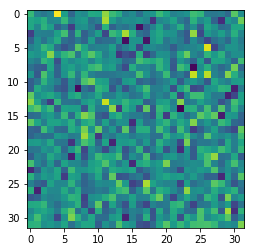

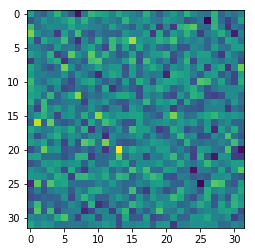

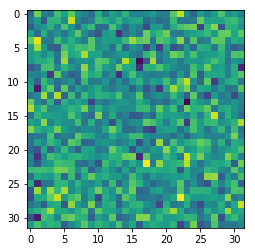

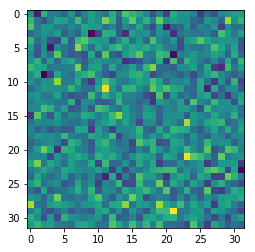

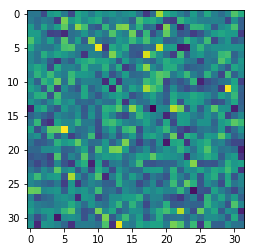

In [184]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)

In [185]:
data_transformed = run_pca(noise_data)

Takes 1.6126759052276611 sec
norm difference between original and reconstructed data:  0.22276318893107033


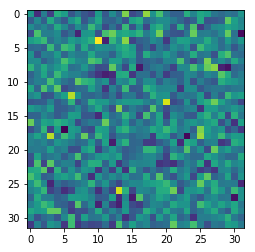

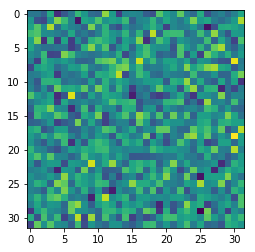

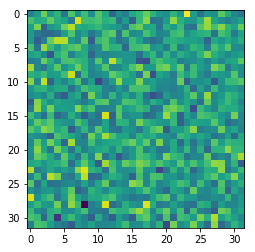

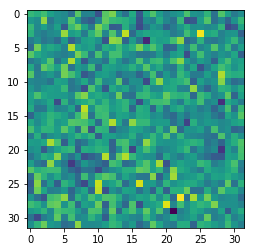

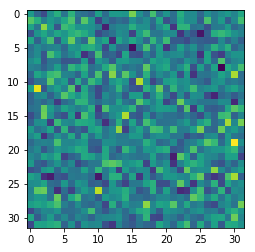

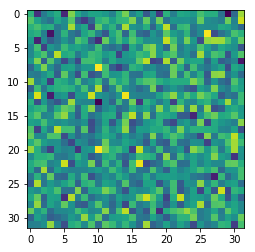

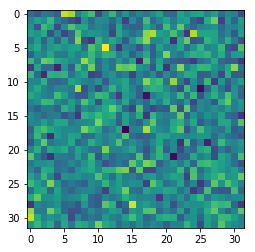

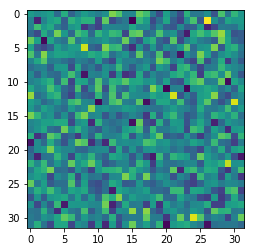

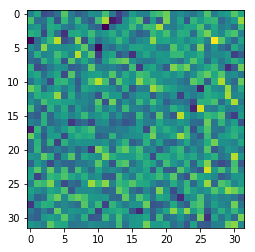

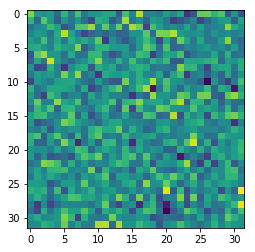

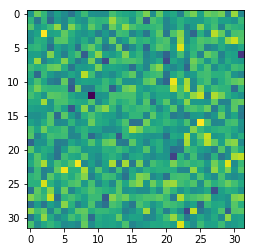

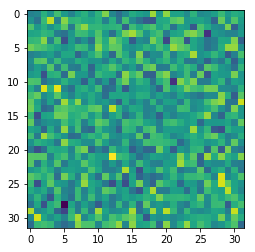

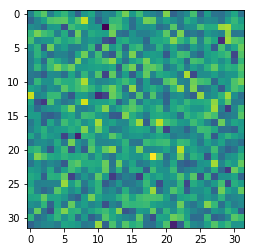

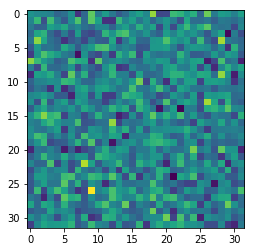

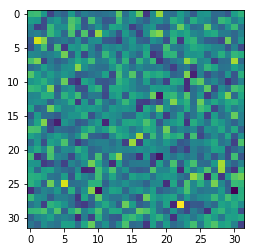

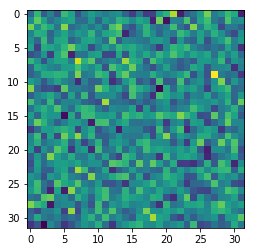

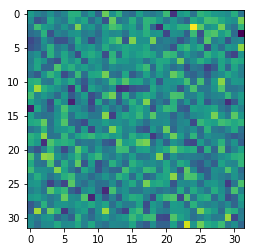

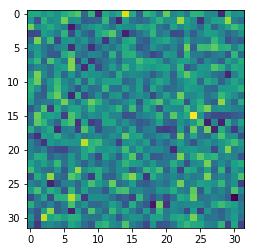

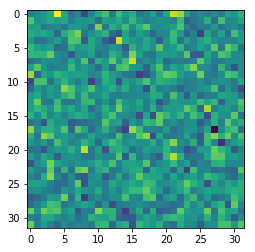

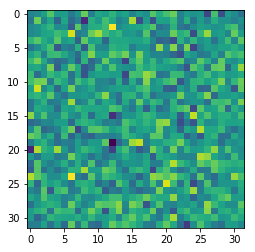

In [186]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


# A component contained only within a single frame

In [187]:
component = ortho_group.rvs(dim=1024)[:100, :]
last_component, component = component[99], component[:99]
loading = np.random.rand(1024, 99)

In [188]:
single_data = loading @ component

In [189]:
new_single = single_data.copy()

for factor in np.arange(0.05, 1, 0.2):
#     new_single[0, :] += last_component * factor
    print("99 components")
    data_transformed = run_pca(new_single, n_components=99)
    print("100 components")
    data_transformed = run_pca(new_single, n_components=100)

99 components
Takes 1.504136085510254 sec
norm difference between original and reconstructed data:  5.98580650392686e-16
100 components
Takes 1.4508113861083984 sec
norm difference between original and reconstructed data:  4.769284761144486e-16
99 components
Takes 1.43963623046875 sec
norm difference between original and reconstructed data:  5.98580650392686e-16
100 components
Takes 1.4129846096038818 sec
norm difference between original and reconstructed data:  4.769284761144486e-16
99 components
Takes 1.446016550064087 sec
norm difference between original and reconstructed data:  5.98580650392686e-16
100 components
Takes 1.424619197845459 sec
norm difference between original and reconstructed data:  4.769284761144486e-16
99 components
Takes 1.4172163009643555 sec
norm difference between original and reconstructed data:  5.98580650392686e-16
100 components
Takes 1.4389023780822754 sec
norm difference between original and reconstructed data:  4.769284761144486e-16
99 components
Takes 1

In [190]:
data_transformed = run_pca(single_data, n_components=100)

Takes 1.4328680038452148 sec
norm difference between original and reconstructed data:  4.769284761144486e-16


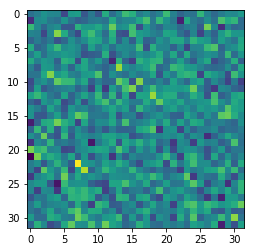

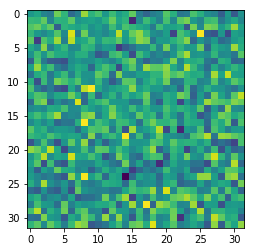

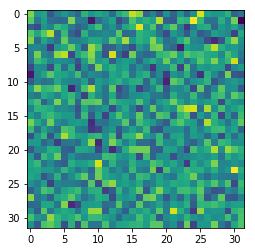

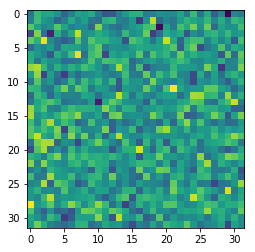

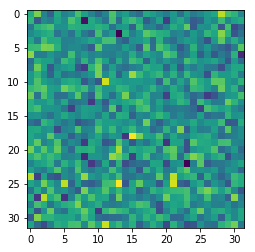

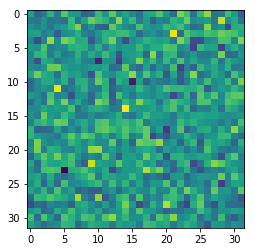

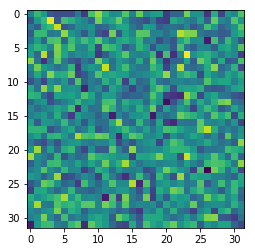

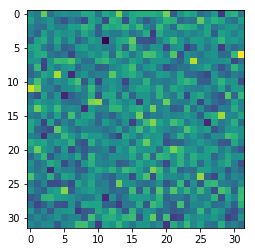

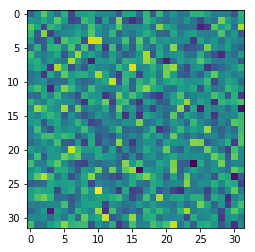

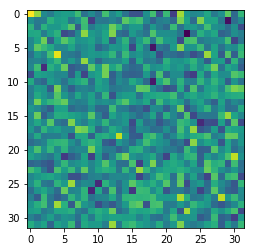

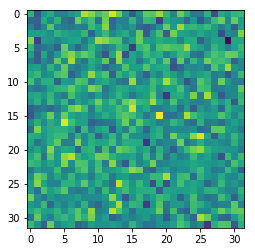

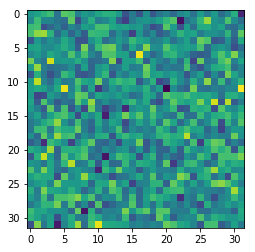

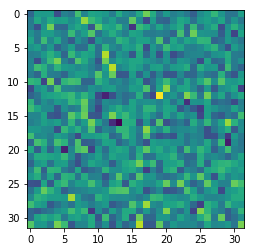

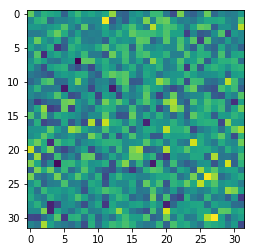

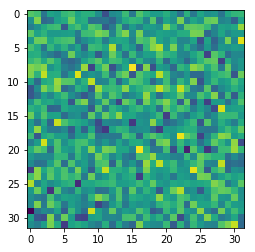

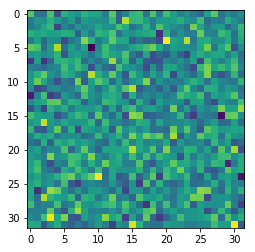

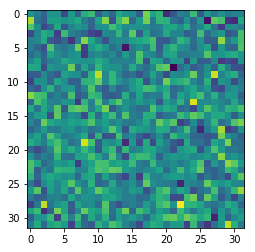

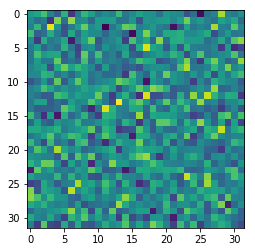

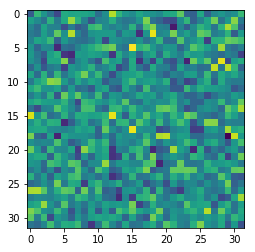

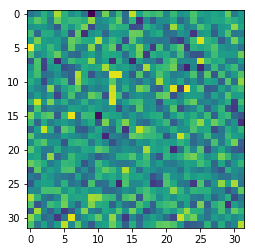

In [191]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


In [192]:
for n_component in range(90, 110, 1):
    U, S, V = svd(single_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 90 components using full batch data: 0.8497097777199937
norm difference wih 91 components using full batch data: 0.8491499823074953
norm difference wih 92 components using full batch data: 0.8487167849815529
norm difference wih 93 components using full batch data: 0.8481836583637365
norm difference wih 94 components using full batch data: 0.8468567618082907
norm difference wih 95 components using full batch data: 0.8457266324194673
norm difference wih 96 components using full batch data: 0.844009760293197
norm difference wih 97 components using full batch data: 0.8434902974045381
norm difference wih 98 components using full batch data: 0.8390921753006729
norm difference wih 99 components using full batch data: 0.8386866722695614
norm difference wih 100 components using full batch data: 0.8371794441618411
norm difference wih 101 components using full batch data: 0.8367230291995037
norm difference wih 102 components using full batch data: 0.831308204358335
norm differ

# Differing intensities of component vectors

In [193]:
component = ortho_group.rvs(dim=1024)[:100, :]

In [194]:
scaler = np.arange(0.01, 11, 0.01)[:1024].T
scaler = scaler.reshape((-1, 1)).T
scaler = np.repeat(scaler, repeats=100, axis=0)
new_component = np.multiply(scaler, component)

loading = np.random.rand(1024, 100)

scaled_data = loading @ new_component

In [195]:
# compare 99 components with 100 components results
data_transformed = run_pca(scaled_data, 99)
data_transformed = run_pca(scaled_data, 100)
data_transformed = run_pca(scaled_data, 101)

Takes 1.72603440284729 sec
norm difference between original and reconstructed data:  0.01498685075294331
Takes 1.5438365936279297 sec
norm difference between original and reconstructed data:  5.706557968238392e-16
Takes 1.5388717651367188 sec
norm difference between original and reconstructed data:  4.425813348880195e-16


# Add Gausian noise to the data

In [196]:
noise = np.random.normal(0, 0.1, size=(1024, 1024))

In [197]:
single_data += noise

for n_component in range(50, 200, 10):
    print(f"Using {n_component} number of components: ")
    data_transformed = run_pca(single_data, n_component)

Using 50 number of components: 
Takes 1.812924861907959 sec
norm difference between original and reconstructed data:  0.2982944977803373
Using 60 number of components: 
Takes 2.2707300186157227 sec
norm difference between original and reconstructed data:  0.2832785853371658
Using 70 number of components: 
Takes 2.036409854888916 sec
norm difference between original and reconstructed data:  0.2695376030837772
Using 80 number of components: 
Takes 1.6888720989227295 sec
norm difference between original and reconstructed data:  0.25687102224978625
Using 90 number of components: 
Takes 1.9278171062469482 sec
norm difference between original and reconstructed data:  0.2453615972614732
Using 100 number of components: 
Takes 1.8140347003936768 sec
norm difference between original and reconstructed data:  0.2355966579552855
Using 110 number of components: 
Takes 1.7485651969909668 sec
norm difference between original and reconstructed data:  0.22997913793732563
Using 120 number of components: 

In [198]:
scaled_data += noise

for n_component in range(50, 200, 10):
    print(f"Using {n_component} number of components: ")
    data_transformed = run_pca(scaled_data, n_component)

Using 50 number of components: 
Takes 1.5972449779510498 sec
norm difference between original and reconstructed data:  0.15092543258445795
Using 60 number of components: 
Takes 1.6157810688018799 sec
norm difference between original and reconstructed data:  0.130137493723048
Using 70 number of components: 
Takes 1.5911335945129395 sec
norm difference between original and reconstructed data:  0.1094679840978821
Using 80 number of components: 
Takes 1.5945632457733154 sec
norm difference between original and reconstructed data:  0.08815277577863273
Using 90 number of components: 
Takes 1.6464293003082275 sec
norm difference between original and reconstructed data:  0.06590473936440235
Using 100 number of components: 
Takes 1.6447932720184326 sec
norm difference between original and reconstructed data:  0.041239602664517476
Using 110 number of components: 
Takes 1.679994821548462 sec
norm difference between original and reconstructed data:  0.04038435073571259
Using 120 number of componen

In [ ]:
data += noise

for n_component in range(50, 200, 10):
    print(f"Using {n_component} number of components: ")
    data_transformed = run_pca(data, n_component)

Using 50 number of components: 
Takes 1.71476411819458 sec
norm difference between original and reconstructed data:  0.29603883641085166
Using 60 number of components: 
Takes 1.6229615211486816 sec
norm difference between original and reconstructed data:  0.28128396783788095
Using 70 number of components: 
Takes 1.6607856750488281 sec
norm difference between original and reconstructed data:  0.26770580754015116
Using 80 number of components: 
Takes 1.6571526527404785 sec
norm difference between original and reconstructed data:  0.2552385919123436
Using 90 number of components: 
Takes 1.6646802425384521 sec
norm difference between original and reconstructed data:  0.2437752475067189
Using 100 number of components: 
Takes 1.7008206844329834 sec
norm difference between original and reconstructed data:  0.23362293974054618
Using 110 number of components: 
Takes 1.7278327941894531 sec
norm difference between original and reconstructed data:  0.2280126506692501
Using 120 number of components